# **Case Datarisk - Score de Crédito**

## **Importa as bibliotecas e Carrega os Dados**

In [1]:
from utils.load_df import load_df
from utils.convert_to_datetime import convert_to_datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

import requests
from pathlib import Path

from sklearn.metrics import roc_curve

In [2]:
# Carregar os DataFrames
df_train = load_df("./data/train.parquet")
df_test = load_df("./data/test.parquet")

X_train = df_train.drop('inadimplente', axis=1)
y_train = df_train['inadimplente']
X_test = df_test.drop('inadimplente', axis=1)
y_test = df_test['inadimplente']

## **Modelagem**

### **Funções**


In [3]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc

def train_and_evaluate_model(model, params, X_train, y_train, X_test):

  # Treinar o modelo
  model.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='pr-auc')

  # Fazer previsões no conjunto de teste
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  y_pred = model.predict(X_test)

  return y_pred_proba, y_pred


In [4]:
def plotProbHistograms(y_pred_proba, y_test, ax):
  """
  Gera e exibe histogramas das probabilidades previstas para múltiplos modelos
  em um eixo matplotlib específico.

  Args:
      y_pred_proba (np.array): Probabilidades previstas para a classe positiva (1).
      y_test (pd.Series): Valores verdadeiros da target.
      ax (matplotlib.axes.Axes): O eixo onde os histogramas serão desenhados.
  """

  df_plot = pd.DataFrame({
      'Probabilidade': y_pred_proba,
      'Classe': y_test.astype(int)
  })

  # Para cada classe, faz um subplot no eixo fornecido
  sns.histplot(
      data=df_plot[df_plot['Classe'] == 0],
      x='Probabilidade',
      bins=30,
      stat='density',
      color='blue',
      label='Classe 0 (Não Inadimplente)',
      kde=True, # Adicionar Kernel Density Estimate para suavizar o histograma
      ax=ax # Especifica o eixo para plotar
  )
  sns.histplot(
      data=df_plot[df_plot['Classe'] == 1],
      x='Probabilidade',
      bins=30,
      stat='density',
      color='red',
      label='Classe 1 (Inadimplente)',
      kde=True, # Adicionar Kernel Density Estimate para suavizar o histograma
      ax=ax # Especifica o eixo para plotar
  )

  ax.set_title('Distribuição das Probabilidades Previstas por Classe', fontsize=14)
  ax.set_xlabel('Probabilidade Prevista')
  ax.set_ylabel('Densidade')
  ax.legend()
  ax.grid(True)

In [5]:
def evaluate_metrics(y_test, y_pred_proba):
    """
    Calcula as principais métricas de avaliação para um modelo de classificação binária.
    Retorna um DataFrame com os valores.
    """

    # AUC ROC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Curva PR e PR-AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc_score = auc(recall_curve, precision_curve)

    # Estatística KS (corrigida)
    df_ks = pd.DataFrame({'proba': y_pred_proba, 'target': y_test})
    df_ks = df_ks.sort_values('proba', ascending=False).reset_index(drop=True)

    df_ks['cum_pos'] = (df_ks['target'] == 1).cumsum() / (df_ks['target'] == 1).sum()
    df_ks['cum_neg'] = (df_ks['target'] == 0).cumsum() / (df_ks['target'] == 0).sum()
    df_ks['ks'] = df_ks['cum_pos'] - df_ks['cum_neg']

    ks_score = df_ks['ks'].max()
    ks_index = df_ks['ks'].idxmax()
    ks_threshold = df_ks['proba'].iloc[ks_index]

    # Precision e Recall no threshold KS
    precision = precision_score(y_test, y_pred_proba >= ks_threshold)
    recall = recall_score(y_test, y_pred_proba >= ks_threshold)

    metrics = pd.DataFrame({
        'Métrica': [
            'AUC (ROC)',
            'PR-AUC',
            'KS Statistic',
            'KS Threshold',
            'Precision (no KS)',
            'Recall (no KS)'
        ],
        'Valor': [
            round(auc_score, 4),
            round(pr_auc_score, 4),
            round(ks_score, 4),
            round(ks_threshold, 4),
            round(precision, 4),
            round(recall, 4)
        ]
    })

    return metrics


def plot_ks_curve(y_test, y_proba, ax: plt.Axes):
    """
    Plota a curva KS (Kolmogorov-Smirnov) em um eixo matplotlib.
    """

    # Preparar dados
    df = pd.DataFrame({'y': y_test, 'proba': y_proba})
    df = df.sort_values('proba', ascending=False).reset_index(drop=True)

    df['cum_pos'] = (df['y'] == 1).cumsum() / (df['y'] == 1).sum()
    df['cum_neg'] = (df['y'] == 0).cumsum() / (df['y'] == 0).sum()
    df['ks'] = df['cum_pos'] - df['cum_neg']

    ks_stat = df['ks'].max()
    ks_idx = df['ks'].idxmax()

    # Plot curvas acumuladas
    ax.plot(df.index / len(df), df['cum_pos'], label="Positivos acumulados", color="blue")
    ax.plot(df.index / len(df), df['cum_neg'], label="Negativos acumulados", color="orange")
    ax.plot(df.index / len(df), df['ks'], label="KS Curve", linestyle="--", color="green")

    # Marcar o ponto máximo do KS
    ax.vlines(ks_idx / len(df),
              ymin=df['cum_neg'].iloc[ks_idx],
              ymax=df['cum_pos'].iloc[ks_idx],
              colors="red", linestyles="dashed")
    ax.text(ks_idx / len(df),
            df['ks'].iloc[ks_idx],
            f"KS = {ks_stat:.2%}", color="red", fontsize=10)

    ax.set_title("Curva KS")
    ax.set_xlabel("Proporção da amostra")
    ax.set_ylabel("Taxa acumulada")
    ax.legend()
    ax.grid(True)

    return ks_stat


def plot_report(y_test, y_pred_proba, title='Relatório de Performance'):
    """
    Gera um dashboard 2x2 com as principais métricas de avaliação para um modelo de classificação binária.
    Inclui AUC, PR-AUC, KS e distribuição de probabilidades.
    """

    # 1. CÁLCULO DAS MÉTRICAS
    metrics = evaluate_metrics(y_test, y_pred_proba)
    display(metrics)

    auc_score = metrics.loc[metrics['Métrica'] == 'AUC (ROC)', 'Valor'].values[0]
    pr_auc_score = metrics.loc[metrics['Métrica'] == 'PR-AUC', 'Valor'].values[0]

    # Curva Precision-Recall
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # 2. DASHBOARD 2x2
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    fig.suptitle(title, fontsize=20)

    # --- Gráfico 1: Curva Precision-Recall ---
    ax1 = axes[0, 0]
    ax1.plot(recall_curve, precision_curve, label=f'PR-AUC = {pr_auc_score:.4f}', color='royalblue')
    ax1.plot([0, 1], [metrics.loc[metrics['Métrica'] == 'Precision (no KS)', 'Valor'].values[0]]*2,
             linestyle="--", color="gray", alpha=0.6, label="Precision @ KS")
    ax1.set_title('Curva Precision-Recall', fontsize=14)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.legend()
    ax1.grid(True)

    # --- Gráfico 2: Curva ROC ---
    ax2 = axes[0, 1]
    ax2.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='darkorange')
    ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax2.set_title('Curva ROC', fontsize=14)
    ax2.set_xlabel('FPR (Taxa de Falsos Positivos)')
    ax2.set_ylabel('TPR (Taxa de Verdadeiros Positivos)')
    ax2.legend()
    ax2.grid(True)

    # --- Gráfico 3: Curva KS ---
    from matplotlib.ticker import PercentFormatter
    ax3 = axes[1, 0]
    ks_value = plot_ks_curve(y_test, y_pred_proba, ax3)
    ax3.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax3.set_title(f'Curva KS (KS={ks_value:.2%})', fontsize=14)

    # --- Gráfico 4: Distribuição das Probabilidades ---
    ax4 = axes[1, 1]
    plotProbHistograms(y_pred_proba, y_test, ax4)
    ax4.set_title('Distribuição das Probabilidades', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [6]:
def plot_feature_importance(feature_importances):

  # Plotar a importância das features
  plt.figure(figsize=(8, 6))
  sns.barplot(x='Importance', y='Feature', data=feature_importances)
  plt.title('Importância das Features')
  plt.xlabel('Importância')
  plt.ylabel('Feature')
  plt.tight_layout()
  plt.show()

In [7]:
params = {
    'class_weight': 'balanced',
    'seed': 42
}

# Criar o modelo LightGBM
model = lgb.LGBMClassifier(**params)
y_pred_proba, y_pred = train_and_evaluate_model(model, params, X_train, y_train, X_test)

[LightGBM] [Info] Number of positive: 3530, number of negative: 82405
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1621
[LightGBM] [Info] Number of data points in the train set: 85935, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


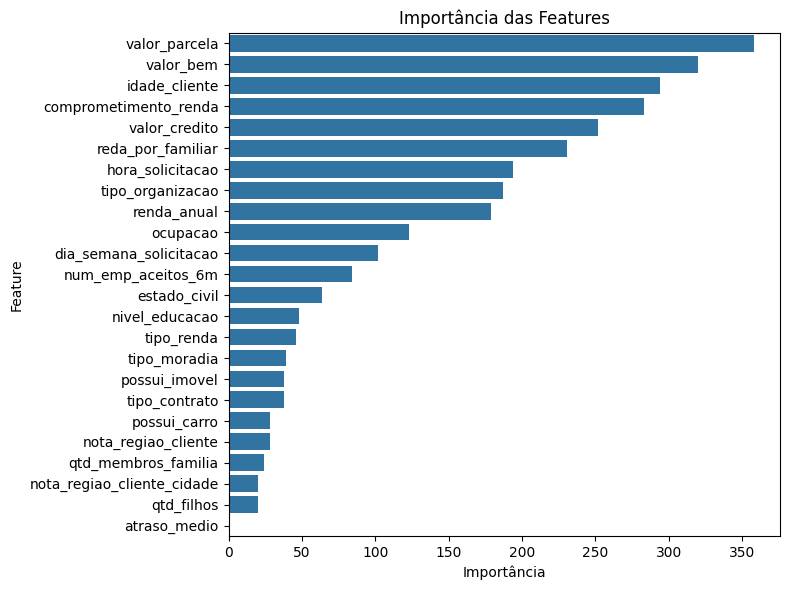

In [8]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plot_feature_importance(feature_importances)

,Métrica,Valor
0,AUC (ROC),0.6453
1,PR-AUC,0.0657
2,KS Statistic,0.2196
3,KS Threshold,0.4314
4,Precision (no KS),0.0580
5,Recall (no KS),0.7211


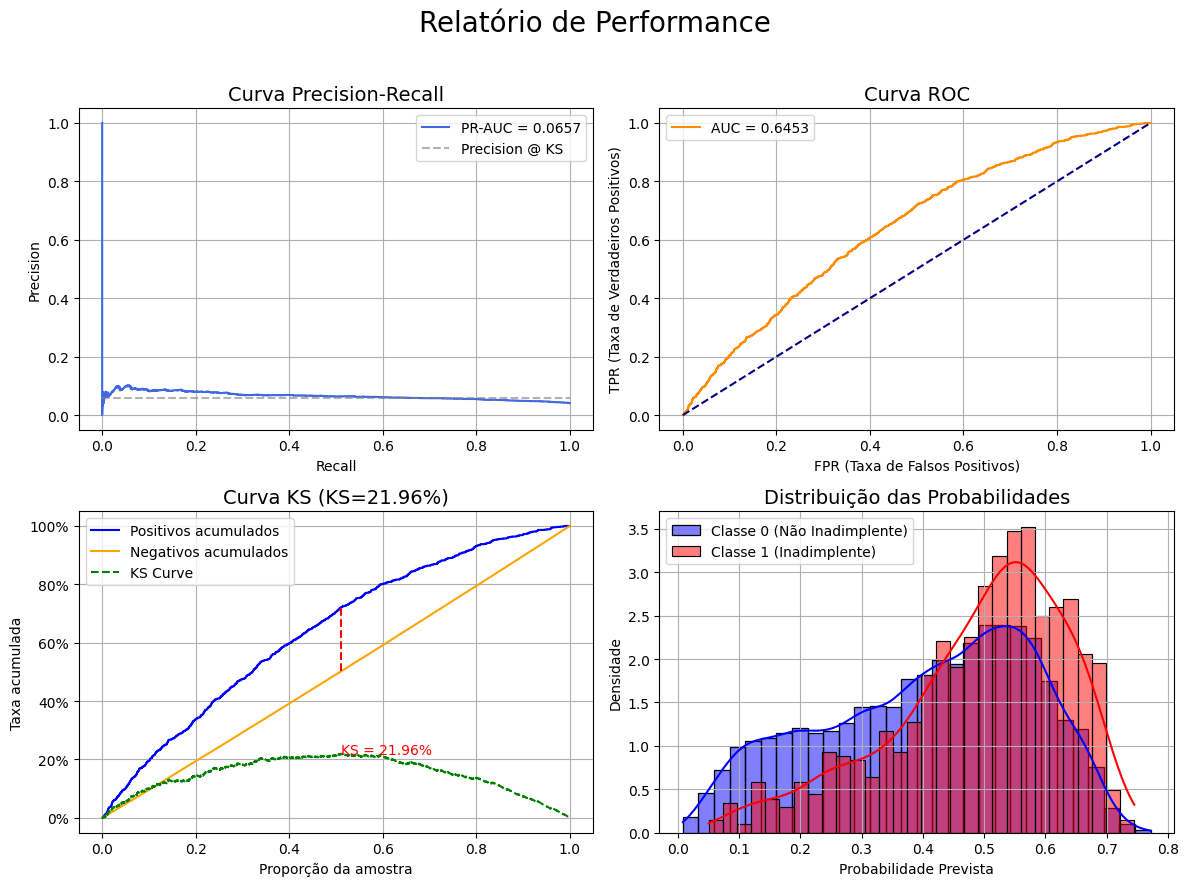

In [9]:
plot_report(y_test, y_pred_proba)

In [10]:
# Descartar features com importância menor que 60
features_to_keep = feature_importances[feature_importances['Importance'] >= 200]['Feature'].tolist()

X_train_less_features = X_train[features_to_keep]
X_test_less_features = X_test[features_to_keep]

print(f"Número de features após descarte: {len(features_to_keep)}")
print("Features restantes:")
print(features_to_keep)

Número de features após descarte: 6
Features restantes:
['valor_parcela', 'valor_bem', 'idade_cliente', 'comprometimento_renda', 'valor_credito', 'reda_por_familiar']


In [11]:
params = {
    'class_weight': 'balanced',
    'seed': 42
}

# Criar o modelo LightGBM
model = lgb.LGBMClassifier(**params)
y_pred_proba, y_pred = train_and_evaluate_model(model, params, X_train_less_features, y_train, X_test_less_features)

[LightGBM] [Info] Number of positive: 3530, number of negative: 82405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 85935, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,Métrica,Valor
0,AUC (ROC),0.6602
1,PR-AUC,0.0712
2,KS Statistic,0.2350
3,KS Threshold,0.5040
4,Precision (no KS),0.0650
5,Recall (no KS),0.6111


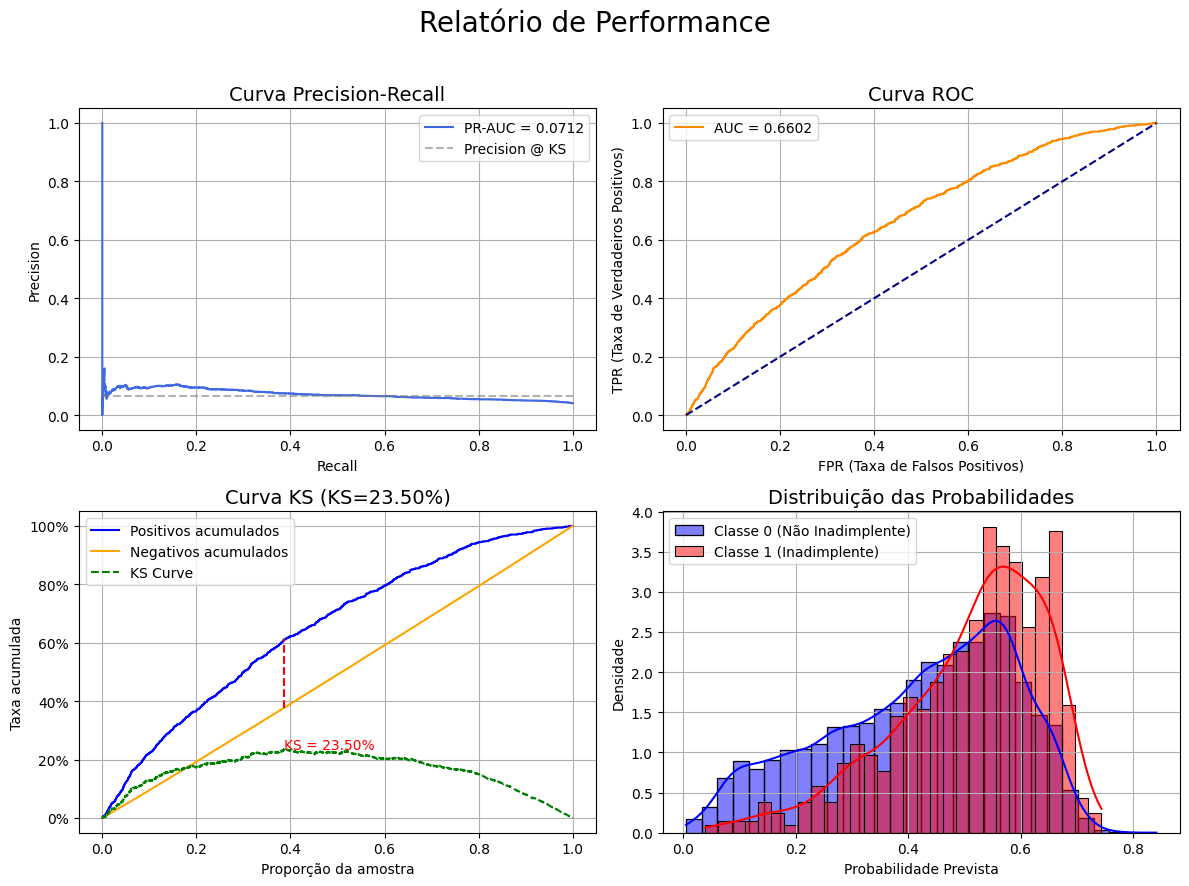

In [12]:
plot_report(y_test, y_pred_proba)

### **SMOTE**

In [13]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [14]:
X_train['valor_bem'].fillna(X_train['valor_bem'].mean(), inplace=True)

/var/folders/py/_hms0lwn3h70z03wxhxl24jm0000gp/T/ipykernel_10379/2180004526.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['valor_bem'].fillna(X_train['valor_bem'].mean(), inplace=True)


In [15]:
counter = Counter(y_train)
print(counter)

Counter({0.0: 82405, 1.0: 3530})


In [16]:
oversample = SMOTE(sampling_strategy=0.1)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [17]:
counter = Counter(y_train_smote)
print(counter)

Counter({0.0: 82405, 1.0: 8240})


In [18]:
model = lgb.LGBMClassifier()
y_pred_proba, y_pred = train_and_evaluate_model(model, params, X_train_smote, y_train_smote, X_test)

[LightGBM] [Info] Number of positive: 8240, number of negative: 82405
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 90645, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090904 -> initscore=-2.302646
[LightGBM] [Info] Start training from score -2.302646


,Métrica,Valor
0,AUC (ROC),0.6385
1,PR-AUC,0.0664
2,KS Statistic,0.2068
3,KS Threshold,0.0537
4,Precision (no KS),0.0596
5,Recall (no KS),0.6383


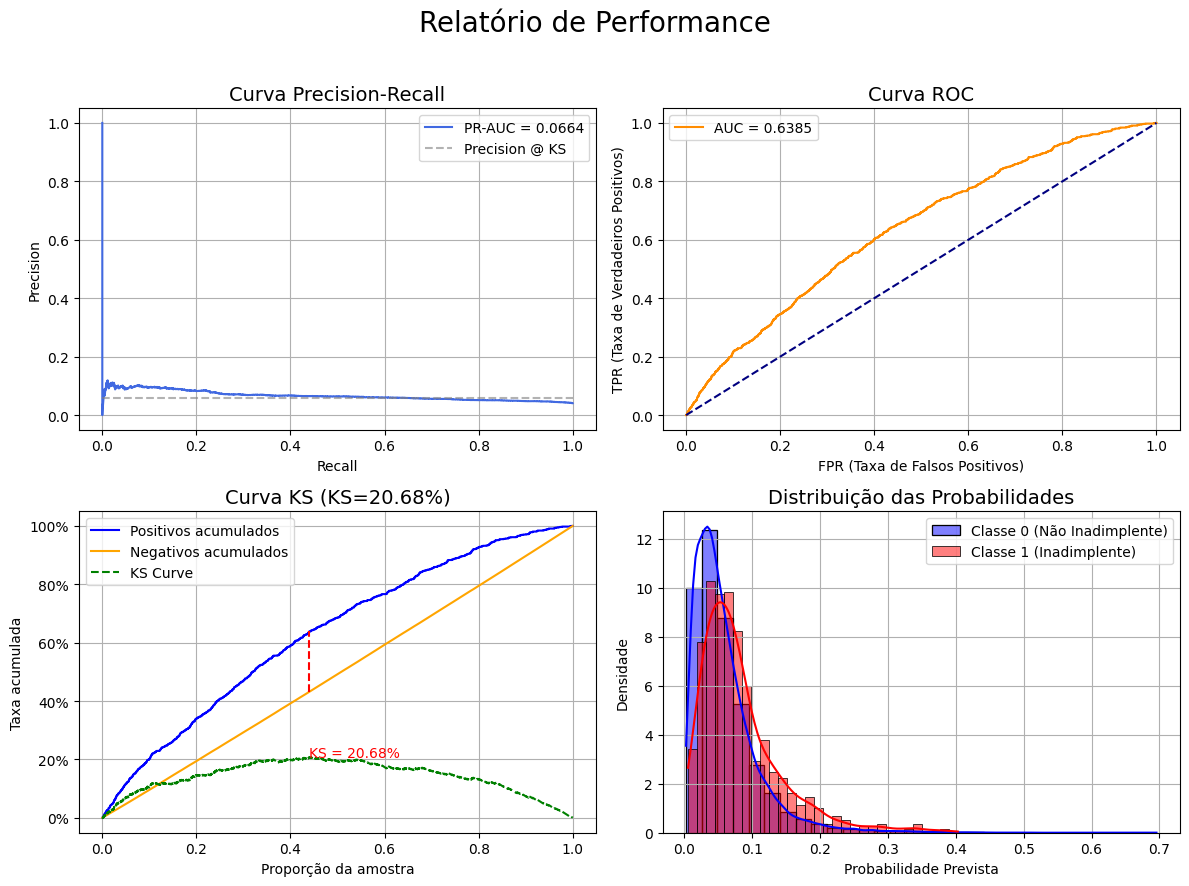

In [19]:
plot_report(y_test, y_pred_proba)

### Referências

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://medium.com/@balemar/t%C3%A9cnicas-para-dados-desbalanceados-smote-e-adasyn-f891f9c46c6e